# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
root = "/data/gpfs/home/tfaske/d/CHDO"

In [4]:
cd $root

/data/gpfs/assoc/denovo/tfaske/CHDO


In [5]:
pwd

'/data/gpfs/assoc/denovo/tfaske/CHDO'

# Sample random fastq for optimizer

    274 CHDO individuals 3 ploidy levels (2x,4x, 6x). 
    Use read count in CHDO known and pick the largest 10 files from 2x,4x and 5 files from 6x
    

 

In [6]:
CHDO_known = pd.read_csv('data/CHDO_known.csv')
CHDO_known.head()


,Sp,Pop,ID,fq,reads,Name,Lat,Long,Ploidy,new_fq
0,CD,AI,1,CD_AI_1,1996065,Arco Hills,43.62136,-113.22755,6,CD6_AI_1
1,CD,AI,10,CD_AI_10,3777792,Arco Hills,43.62136,-113.22755,6,CD6_AI_10
2,CD,AI,11,CD_AI_11,2538769,Arco Hills,43.62136,-113.22755,6,CD6_AI_11
3,CD,AI,2,CD_AI_2,3493929,Arco Hills,43.62136,-113.22755,6,CD6_AI_2
4,CD,AI,3,CD_AI_3,2701044,Arco Hills,43.62136,-113.22755,6,CD6_AI_3


In [7]:
CHDO_known.sort_values('reads',axis=0,ascending=False,inplace=True)
CHDO_known.loc[:10,]

,Sp,Pop,ID,fq,reads,Name,Lat,Long,Ploidy,new_fq
1,CD,AI,10,CD_AI_10,3777792,Arco Hills,43.62136,-113.22755,6,CD6_AI_10
119,CD,MC,6,CD_MC_6,3553473,Mann Creek Reservoir,44.39673,-116.90020,4,CD4_MC_6
3,CD,AI,2,CD_AI_2,3493929,Arco Hills,43.62136,-113.22755,6,CD6_AI_2
148,CD,OV,10,CD_OV_10,3480636,Onion Valley Reservoir,41.69626,-118.74330,4,CD4_OV_10
16,CD,AO,6,CD_AO_6,3436789,Asotin,46.26210,-117.29850,6,CD6_AO_6
15,CD,AO,5,CD_AO_5,3410231,Asotin,46.26210,-117.29850,6,CD6_AO_5
114,CD,MC,12,CD_MC_12,3355766,Mann Creek Reservoir,44.39673,-116.90020,4,CD4_MC_12
189,CD,SA,4,CD_SA_4,3343058,South Alkali,44.02841,-117.19350,2,CD2_SA_4
183,CD,SA,1,CD_SA_1,3285414,South Alkali,44.02841,-117.19350,2,CD2_SA_1
268,CD,WM,4,CD_WM_4,3254557,Winnemucca Mountain,41.01334,-117.78088,4,CD4_WM_4


In [11]:
fq_2x = CHDO_known[CHDO_known.Ploidy == 2].new_fq[:10]
fq_4x = CHDO_known[CHDO_known.Ploidy == 4].new_fq[:10]
fq_6x = CHDO_known[CHDO_known.Ploidy == 6].new_fq[:5]

In [13]:
fq_keep = fq_2x.tolist() + fq_4x.tolist() + fq_6x.tolist()
len(fq_keep),fq_keep[:5]

(25, ['CD2_SA_4', 'CD2_SA_1', 'CD2_PM_5', 'CD2_RC_5', 'CD2_PM_10'])

In [14]:
!mkdir refOpt

mkdir: cannot create directory ‘refOpt’: File exists


In [15]:
for fq in fq_keep:
    fq_full = 'fastq_known/' + fq + '.F.fq.gz'
    !cp $fq_full refOpt/

In [16]:
!ls -l refOpt/*gz | wc -l 

25


# make a slurm script to run ReferenceOpt.sh 
    ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
    
    **NOTE:** must run dDocent to at least trim first 

In [17]:
refOpt = '/data/gpfs/home/tfaske/g/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = '/data/gpfs/home/tfaske/d/CHDO/refOpt'

In [18]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/refOpt


In [19]:
### select options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
jobname = 'sagebrush'
time = '4-00:00:00' #time limit 4 days
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
cpus = 64
mem_cpu = 2500
email = 'tfaske@nevada.unr.edu'

In [20]:
def write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type):
    with open("run_refOpt.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name refOpt
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=BEGIN,END
#SBATCH --mail-user=%s\n\n""" % (account,partition,int(cpus),int(mem_cpu),jobname,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("""%s %d %d %d %d %s %d"""% (refOpt,minK1,maxK1,minK2,maxK2,Type,cpus))

In [21]:
write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type)

# run refOpt.sh in slurm
    cd /data/gpfs/home/tfaske/d/sagebrush/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt

In [22]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/refOpt


In [23]:
!tail output_refOpt.txt

The top three most common number of contigs
X	Contig number
5	97
5	87
4	116
The top three most common number of contigs (with values rounded)
X	Contig number
38	100
21	200
11	2000


In [24]:
%load_ext rpy2.ipython

R[write to console]: 
── Column specification ────────────────────────────────────────
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)




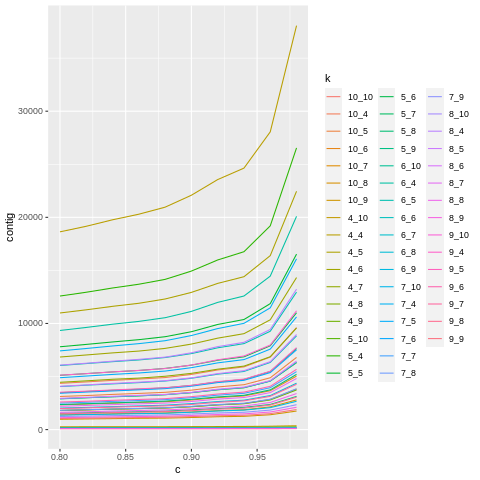

In [25]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .96 is the winner!

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 94 add (e.g. 90,92,96)

In [26]:
cd $root

/data/gpfs/assoc/denovo/tfaske/CHDO


In [27]:
!mkdir mapOpt

mkdir: cannot create directory ‘mapOpt’: File exists


In [28]:
mapOpt_dir = os.path.join(root,'mapOpt/')
assert mapOpt_dir

In [29]:
sim_val = [92,94,96,98]

In [30]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    !mkdir $mapsim

In [32]:
### cp fastq from refOpt
fq_files = !find $refOpt_dir -name '*fq.gz'
fq_files = [os.path.abspath(x) for x in fq_files]
len(fq_files),fq_files[0]

(50, '/data/gpfs/home/tfaske/d/CHDO/refOpt/CD2_SA_1.R1.fq.gz')

In [33]:
for fq in fq_files:   
    for sim in sim_val:
        mapsim = "mapOpt/mapOpt%d" % (sim)
        !cp $fq $mapsim

In [34]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    logfiles = os.path.join(refOpt_dir,'logfiles')
    !cp -r $logfiles $mapsim

In [35]:
src_dir = '/data/gpfs/home/tfaske/g/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [36]:
len(mapOpt_sh), mapOpt_sh

(4,
 ['/data/gpfs/home/tfaske/g/src/refOpt/./Map92.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map94.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map96.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map98.sh'])

In [37]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4 days
cpus = 16
mem_cpu = 2500

#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 

In [38]:
cd $mapOpt_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/mapOpt


In [39]:
def write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("mapOpt%d/run_mapOpt%d.sh" % (sim,sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,int(cpus),int(mem_cpu),sim,sim,email))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,cpus))

In [40]:
write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type)

In [41]:
mapShells = !find $mapOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/home/tfaske/d/CHDO/mapOpt/mapOpt94/run_mapOpt94.sh',
 '/data/gpfs/home/tfaske/d/CHDO/mapOpt/mapOpt96/run_mapOpt96.sh',
 '/data/gpfs/home/tfaske/d/CHDO/mapOpt/mapOpt92/run_mapOpt92.sh',
 '/data/gpfs/home/tfaske/d/CHDO/mapOpt/mapOpt98/run_mapOpt98.sh']

In [42]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [43]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh (doesnt work, run mapOpt in each dir)
    cd /data/gpfs/home/tfaske/d/sagebrush/mapOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [46]:
cd $root

/data/gpfs/assoc/denovo/tfaske/CHDO


In [47]:
mapResults = !find . -name 'mapping*results'
mapResults

['./mapOpt/mapOpt94/mapping94.results',
 './mapOpt/mapOpt96/mapping96.results',
 './mapOpt/mapOpt92/mapping92.results',
 './mapOpt/mapOpt98/mapping98.results']

In [48]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

./mapOpt/mapOpt94/mapping94.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
77.7779	83.614	24637	22909	4	4	36409550	0	1.91629e+06	0	0
126.042	131.547	14406	13792.2	4	5	34501874	0	1.81589e+06	0	0
191.731	196.331	9039	8820.53	4	6	32931719	0	1.73325e+06	0	0
276.868	280.231	5982	5907.42	4	7	31473474	0	1.6565e+06	0	0
398.759	400.921	3942	3920.58	4	8	29873858	0	1.57231e+06	0	0
602.956	604.06	2444	2440.37	4	9	28010318	0	1.47423e+06	0	0
3009.02	3020.07	297	296.895	4	10	17037065	0	896688	0	0
110.03	116.51	16760	15815.5	5	4	35040165	0	1.84422e+06	0	0
169.139	174.938	10373	10019.6	5	5	33338357	0	1.75465e+06	0	0
244.699	249.301	6857	6725	5	6	31884694	0	1.67814e+06	0	0
340.334	343.564	4727	4680.79	5	7	30572897	0	1.6091e+06	0	0
474.522	476.3	3232	3220.21	5	8	29148438	0	1.53413e+06	0	0
685.202	686.304	2094	2091.53	5	9	27274457	0	1.4355e+06	0	0
3751.39	3768.97	221	220.947	5	10	15823365	0	832809	0	0
141.663	148.513	12587	11993.3	6	4	33881



./mapOpt/mapOpt98/mapping98.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
42.5806	46.8201	38059	34668.3	4	4	29171118	0	1.62062e+06	0	0
68.9893	72.7315	22453	21310.9	4	5	27883543	0	1.54909e+06	0	0
103.67	106.72	14326	13920.2	4	6	26735098	0	1.48528e+06	0	0
149.046	151.527	9574	9418.89	4	7	25688061	0	1.42711e+06	0	0
217.224	218.964	6305	6256.17	4	8	24656625	0	1.36981e+06	0	0
345.435	346.407	3740	3730.56	4	9	23260911	0	1.29227e+06	0	0
2278.05	2285.44	364	363.833	4	10	14966809	0	831489	0	0
58.7962	63.4622	26539	24611.7	5	4	28088109	0	1.56045e+06	0	0
90.7103	94.6018	16533	15858.1	5	5	26996481	0	1.4998e+06	0	0
130.774	133.825	11010	10760.6	5	6	25919054	0	1.43995e+06	0	0
181.695	183.94	7643	7550.94	5	7	24999747	0	1.38887e+06	0	0
256.007	257.489	5208	5179.11	5	8	24003751	0	1.33354e+06	0	0
402.746	403.647	3129	3123	5	9	22690697	0	1.26059e+06	0	0
3043.77	3056.35	256	255.944	5	10	14080478	0	782249	0	0
75.5916	80.5255	20092	18873.

In [49]:
%%R 
library(readr)
library(data.table)
setwd('/data/gpfs/assoc/denovo/tfaske/CHDO/mapOpt')

mapping92 <- read_table2('mapOpt92/mapping92.results')
mapping92$k <- paste0(mapping92$K1,'_',mapping92$K2)
mapping92$sim <- '92'
mapping92$ratio <- abs( scale(mapping92$SUM_1) / (scale(mapping92$MeanContigsMapped) / scale(mapping92$Cov) ) ) 


mapping94 <- read_table2('mapOpt94/mapping94.results')
mapping94$k <- paste0(mapping94$K1,'_',mapping94$K2)
mapping94$sim <- '94'
mapping94$ratio <- abs( scale(mapping94$SUM_1) / (scale(mapping94$MeanContigsMapped) / scale(mapping94$Cov) ) ) 

mapping96 <- read_table2('mapOpt96/mapping96.results')
mapping96$k <- paste0(mapping96$K1,'_',mapping96$K2)
mapping96$sim <- '96'
mapping96$ratio <- abs( scale(mapping96$SUM_1) / (scale(mapping96$MeanContigsMapped) / scale(mapping96$Cov) ) )

mapping98 <- read_table2('mapOpt98/mapping98.results')
mapping98$k <- paste0(mapping98$K1,'_',mapping98$K2)
mapping98$sim <- '98'
mapping98$ratio <- abs( scale(mapping98$SUM_1) / (scale(mapping98$MeanContigsMapped) / scale(mapping98$Cov) ) ) 

#print(mapping92)
#print(mapping94)
#print(mapping96)

#map_df
map_df <- rbindlist(list(mapping98,mapping92,mapping94,mapping96))
head(map_df)

R[write to console]: 
── Column specification ────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)


R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  2  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  3  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  4  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  5  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
... ... .......... .......... ............................
See problems(...) for m

        Cov  Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1:  42.5806  46.8201   38059          34668.30  4  4 29171118      0 1620620
2:  68.9893  72.7315   22453          21310.90  4  5 27883543      0 1549090
3: 103.6700 106.7200   14326          13920.20  4  6 26735098      0 1485280
4: 149.0460 151.5270    9574           9418.89  4  7 25688061      0 1427110
5: 217.2240 218.9640    6305           6256.17  4  8 24656625      0 1369810
6: 345.4350 346.4070    3740           3730.56  4  9 23260911      0 1292270
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim      ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  98 0.17495466
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  98 0.26199865
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  98 0.40584640
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  98 0.85489731
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  98 1.02542517
6:        0    0 

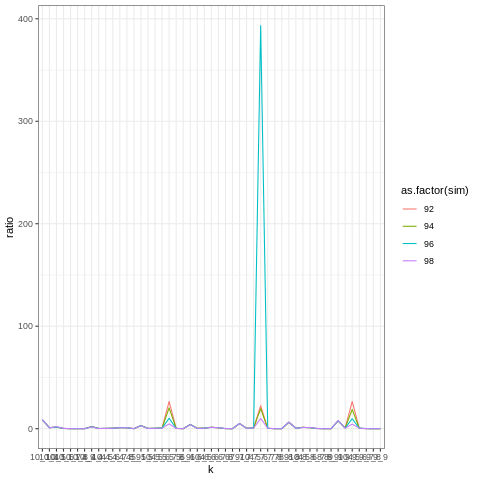

In [50]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [51]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     9.809895e+02      9.887925e+02      5.584474e+03      5.410035e+03 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      2.665343e+07      1.400922e+06 


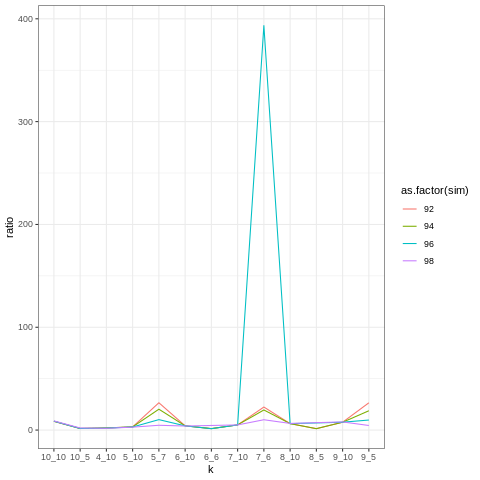

In [52]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [54]:
%%R
names(map_df)

 [1] "Cov"               "Non0Cov"           "Contigs"          
 [4] "MeanContigsMapped" "K1"                "K2"               
 [7] "SUM"               "Mapped"            "SUM_1"            
[10] "Properly"          "Mean"              "Mapped_1"         
[13] "Mean_1"            "Properly_1"        "MisMatched"       
[16] "k"                 "sim"               "ratio"            


In [55]:
%%R
map_df[which(map_df$k %in% c('5_7','7_6','9_5')),c(1:7,9,17,18)]

        Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
 1: 181.695 183.940    7643           7550.94  5  7 24999747 1388870  98
 2: 185.096 187.994    7518           7403.44  7  6 25051304 1391740  98
 3: 180.325 183.852    7722           7575.22  9  5 25067729 1392650  98
 4: 360.909 364.388    4494           4449.42  5  7 30823445 1622290  92
 5: 363.254 367.316    4431           4379.89  7  6 30588918 1609940  92
 6: 357.343 362.931    4521           4448.26  9  5 30702173 1615900  92
 7: 340.334 343.564    4727           4680.79  5  7 30572897 1609100  94
 8: 344.008 347.771    4644           4591.53  7  6 30360427 1597920  94
 9: 337.134 342.281    4758           4683.16  9  5 30483999 1604421  94
10: 285.692 288.119    5468           5420.25  5  7 31249049 1562450  96
11: 289.176 292.157    5373           5316.15  7  6 31080656 1554030  96
12: 282.604 286.575    5498           5418.75  9  5 31080752 1554040  96
         ratio
 1:   4.689886
 2:  10.064472
 3:   

# Map results 
    sim=96 K1=7 k2=6 WINNER
    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir